In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import calculations
import agent
import environment

In [2]:
def train(env, agent, num_iterations, algo, learning_rate, lam):
    weights = []
    new_weight = np.zeros(agent.num_features)
    z = np.zeros(agent.num_features)
    
    cur_st = env.state
    cur_sib_st = cur_st
    
    for ctr in range(1, num_iterations+1):
        # Perform action in environment using current weights self.w
        act = agent.get_action(cur_st)
        next_st, reward = env.step(act)

        # Get next sibling state
        next_sib_st, _ = calculations.sibling(cur_st, act, next_st, env.transition_matrix)

        # Sample reward from current sibling state
        env_clone = deepcopy(env)
        env_clone.state = cur_sib_st
        _, reward_sib = env_clone.step(agent.get_action(cur_sib_st))

        # Update eligibility traces and weights based on chosen algorithm
        if algo == 'TD':
            featdiff = env.gamma * agent.features[next_st] - agent.features[cur_st]
            d = reward + sum(featdiff * new_weight)
            new_weight = new_weight + learning_rate * d * z / ctr
            z = env.gamma * lam * z + agent.features[next_st]

        elif algo == 'STD-99':
            featdiff = env.gamma * (agent.features[next_st] - agent.features[next_sib_st]) - (
                agent.features[cur_st] - agent.features[cur_sib_st])
            d = reward + sum(featdiff * new_weight)
            new_weight = new_weight + learning_rate * d * z / ctr
            z = env.gamma * lam * z + agent.features[next_st] - agent.features[next_sib_st]

        elif algo == 'STD-01':
            featdiff = gamma * (agent.features[next_st] - agent.features[next_sib_st]) - (
                agent.features[cur_st] - agent.features[cur_sib_st])
            d = reward - reward_sib + sum(featdiff * new_weight)
            new_weight = new_weight + learning_rate * d * z / ctr
            z = gamma * lam * z + (agent.features[next_st] - agent.features[next_sib_st]) / \
                env.transition_matrix[cur_st][act][next_st]

        # update historical sibling states
        cur_st = next_st
        cur_sib_st = next_sib_st
        weights.append(new_weight)
    agent.weight = new_weight
    return weights

In [3]:
num_states = 2
num_actions = 2

# Randomly initialize transition_matrix, rewards, alpha, and features
transition_matrix = np.random.rand(num_states,num_actions,num_states)
for i in range(num_states):
    for j in range(num_actions):
        transition_matrix[i][j] = transition_matrix[i][j] / sum(transition_matrix[i][j])
rewards = np.random.rand(num_states,num_states)*2 - 1
gamma = np.random.rand(1)[0]
features = np.random.rand(num_states,num_states-1)*2

# Calculate value function for each policy
policy_values = calculations.policy_values(transition_matrix, rewards, gamma)
optimal_policy = max(list(policy_values.items()), key=lambda x: sum(x[1]))[0]

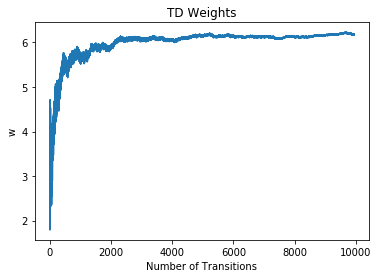

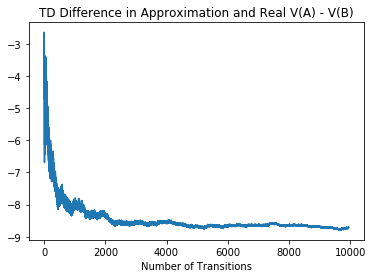

In [7]:
# Set up environment
env = environment.Environment(transition_matrix, rewards, gamma)

# Set up and run policy iteration on agent
td_agent = agent.Agent(features, optimal_policy)
td_weights = train(env, td_agent, num_iterations=10000, algo="TD", learning_rate=2.0, lam=1.0)
td_agent.policy = calculations.make_new_policy(td_agent, td_weights[-1], transition_matrix, rewards, gamma)

# Plot weight values at each iteration
plt.plot(td_weights[50:])
plt.xlabel("Number of Transitions")
plt.ylabel("w")
plt.title("TD Weights")
plt.show()
print()

# Plot value differences at each iteration
stdAB = calculations.value_difference([1,-1], features, td_weights, optimal_policy, policy_values)
plt.plot(stdAB[50:])
plt.xlabel("Number of Transitions")
plt.title("TD Difference in Approximation and Real V(A) - V(B)")
plt.show()


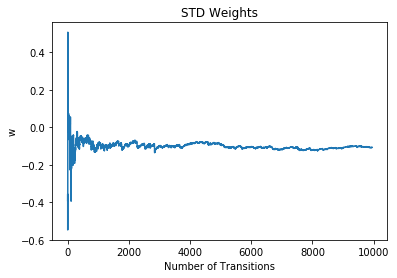

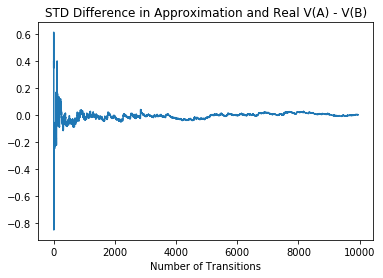

In [5]:
# Set up environment
env = environment.Environment(transition_matrix, rewards, gamma)

# Set up and run policy iteration on agent
std_agent = agent.Agent(features, optimal_policy)
std_weights = train(env, std_agent, num_iterations=10000, algo="STD-01", learning_rate=2.0, lam=1.0)
std_agent.policy = calculations.make_new_policy(std_agent, std_weights[-1], transition_matrix, rewards, gamma)

# Plot weight values at each iteration
plt.plot(std_weights[50:])
plt.xlabel("Number of Transitions")
plt.ylabel("w")
plt.title("STD Weights")
plt.show()
print()

# Plot value differences at each iteration
stdAB = calculations.value_difference([1,-1], features, std_weights, optimal_policy, policy_values)
plt.plot(stdAB[50:])
plt.xlabel("Number of Transitions")
plt.title("STD Difference in Approximation and Real V(A) - V(B)")
plt.show()


In [8]:
pd.DataFrame(np.array([[optimal_policy, td_agent.policy, std_agent.policy],
list(map(lambda x: sum(policy_values[x]), [optimal_policy, td_agent.policy, std_agent.policy]))]),
            ["Policy", "Policy Value"], ["Optimal", "TD", "STD"])

,Optimal,TD,STD
Policy,"(1, 0)","(0, 1)","(1, 0)"
Policy Value,18.2646,16.8625,18.2646
